In [1]:
import sent2vec
cleaned_expression_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_otherexpr.csv")]
cleaned_kinaseact_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/clean_with_negative_kinaseact.csv")]
cleaned_expression_data = [[row[0], int(row[1]), row[2]] for row in cleaned_expression_data]
cleaned_kinaseact_data = [[row[0], int(row[1]), row[2]] for row in cleaned_kinaseact_data]
bio_sent_vec_model_location = "../biosentvec/model.bin"

In [2]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [3]:
corpus_expr = biosentvec_model.embed_sentences([row[0] for row in cleaned_expression_data])
corpus_kinaseact = biosentvec_model.embed_sentences([row[0] for row in cleaned_kinaseact_data])

In [4]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

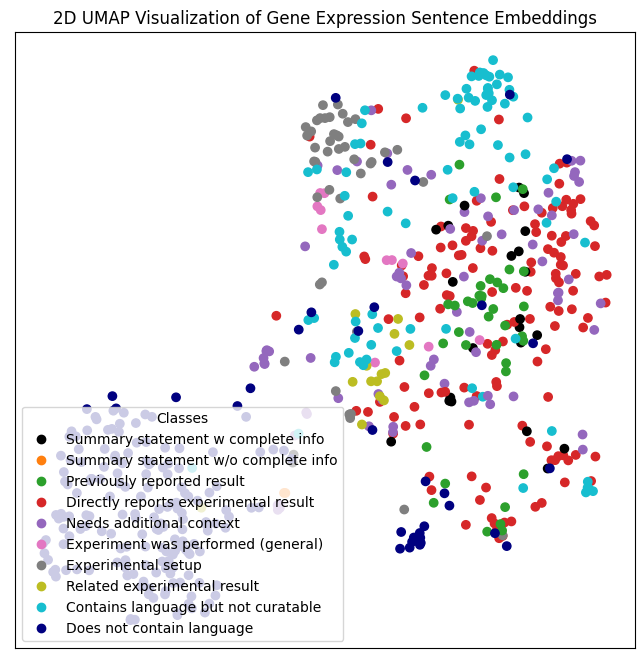

In [5]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

colors = ListedColormap(['black','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan', 'navy'])
values = [int(row[1]) for row in cleaned_expression_data]
classes = ['Summary statement w complete info', 'Summary statement w/o complete info', 'Previously reported result', 'Directly reports experimental result', 'Needs additional context', 'Experiment was performed (general)', 'Experimental setup', 'Related experimental result', 'Contains language but not curatable', 'Does not contain language']
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=values, cmap=colors)
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Gene Expression Sentence Embeddings")
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

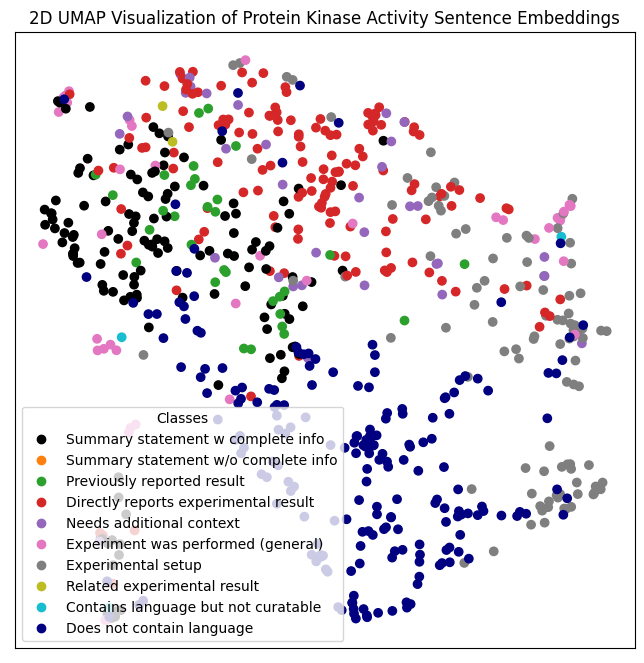

In [6]:
values = [int(row[1]) for row in cleaned_kinaseact_data]
fig, ax = plt.subplots(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Protein Kinase Activity Sentence Embeddings")
ax.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=values, cmap=colors)
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

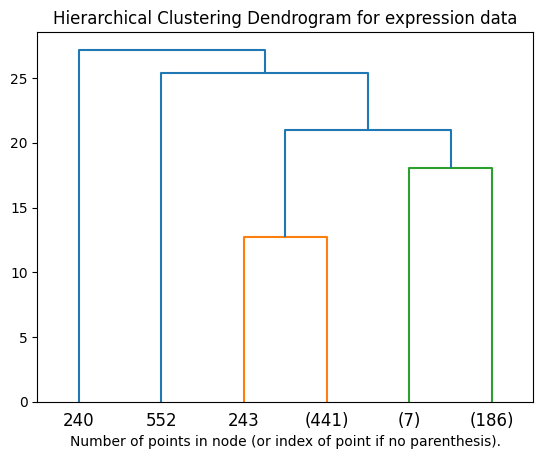

In [7]:
from sentence_classification.clustering import plot_dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

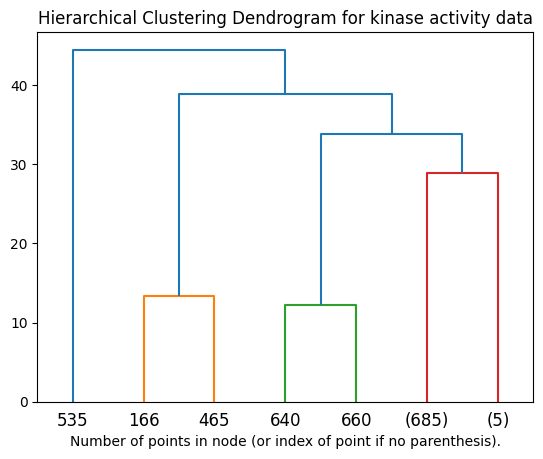

In [8]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# classifiers

In [9]:
from random import shuffle
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr
converted_corpus_kinaseact = corpus_kinaseact
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][1] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in test_indices_kinaseact]
base_clf = MLPClassifier(hidden_layer_sizes=(10, 10), alpha=0.1)

# prediction
## multiclass

In [10]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][1] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.66666667 0.44117647 0.66666667 1.         0.5
 0.         0.54166667 0.93333333]
recall: [0.         0.36363636 0.78947368 0.31578947 0.5        0.28571429
 0.         0.72222222 0.93333333]
fscore: [0.         0.47058824 0.56603774 0.42857143 0.66666667 0.36363636
 0.         0.61904762 0.93333333]
support: [ 5 11 19 19  2  7  1 18 45]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][1] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.43478261 0.         0.69230769 0.16666667 1.         0.82608696
 0.         0.91176471]
recall: [0.95238095 0.         0.64285714 0.09090909 0.66666667 0.82608696
 0.         0.83783784]
fscore: [0.59701493 0.         0.66666667 0.11764706 0.8        0.82608696
 0.         0.87323944]
support: [21 12 28 11  6 23  1 37]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### 1. Classifier that extracts sentences that contain all the information necessary to make an annotation.

In [12]:
import joblib
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94949495 0.67857143]
recall: [0.91262136 0.79166667]
fscore: [0.93069307 0.73076923]
support: [103  24]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8982968038086148
recall: 0.889763779527559
fscore: 0.8929121864336645
support: None


In [14]:
final_set_classes_expr = [1 if sentence[1] in [0, 3] else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expr)
joblib.dump(clf, '../classifiers/all_info_expression.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../classifiers/all_info_expression.joblib']

In [15]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9125     0.66101695]
recall: [0.78494624 0.84782609]
fscore: [0.84393064 0.74285714]
support: [93 46]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8292753932447263
recall: 0.8057553956834532
fscore: 0.8104818539883205
support: None


In [17]:
final_set_classes_kinase = [1 if sentence[1] in [0, 3] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../classifiers/all_info_kinase.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../classifiers/all_info_kinase.joblib']

### 2. Classifier that extracts sentences that contain curatable information

In [18]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
joblib.dump(clf, '../classifiers/curatable_expression.joblib')

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90588235 0.83333333]
recall: [0.91666667 0.81395349]
fscore: [0.9112426  0.82352941]
support: [84 43]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: 0.8813185116566312
recall: 0.8818897637795275
fscore: 0.8815444362528125
support: None


In [20]:
final_set_classes_expression = [1 if sentence[1] in [0, 1, 3, 4] else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expression)
joblib.dump(clf, '../classifiers/curatable_expression.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../classifiers/curatable_expression.joblib']

In [21]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
joblib.dump(clf, '../classifiers/curatable_kinase.joblib')

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93055556 0.73134328]
recall: [0.78823529 0.90740741]
fscore: [0.85350318 0.80991736]
support: [85 54]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8531637376665832
recall: 0.8345323741007195
fscore: 0.8365705603648891
support: None


In [23]:
final_set_classes_kinase = [1 if sentence[1] in [0, 1, 3, 4] and sentence[2] in ['positive', 'both'] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../classifiers/curatable_kinase.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../classifiers/curatable_kinase.joblib']

### 3. Classifier that extracts sentences that contain language

In [24]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
joblib.dump(clf, '../classifiers/language_expression.joblib')

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [1.         0.98795181]
recall: [0.97777778 1.        ]
fscore: [0.98876404 0.99393939]
support: [45 82]


In [25]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9922208519115833
recall: 0.9921259842519685
fscore: 0.9921056088622222
support: None


In [26]:
final_set_classes_expression = [1 if sentence[1] < 9 else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expression)
joblib.dump(clf, '../classifiers/language_expression.joblib')

['../classifiers/language_expression.joblib']

In [27]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
joblib.dump(clf, '../classifiers/language_kinase.joblib')

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.875 0.76 ]
recall: [0.75675676 0.87692308]
fscore: [0.8115942  0.81428571]
support: [74 65]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8212230215827339
recall: 0.8129496402877698
fscore: 0.812852823331397
support: None


In [29]:
final_set_classes_kinase = [1 if sentence[1] < 9 and sentence[2] in ['positive', 'both'] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../classifiers/language_kinase.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../classifiers/language_kinase.joblib']

# Feature analysis for positive sentences

## expression

(0.0, 210.0)

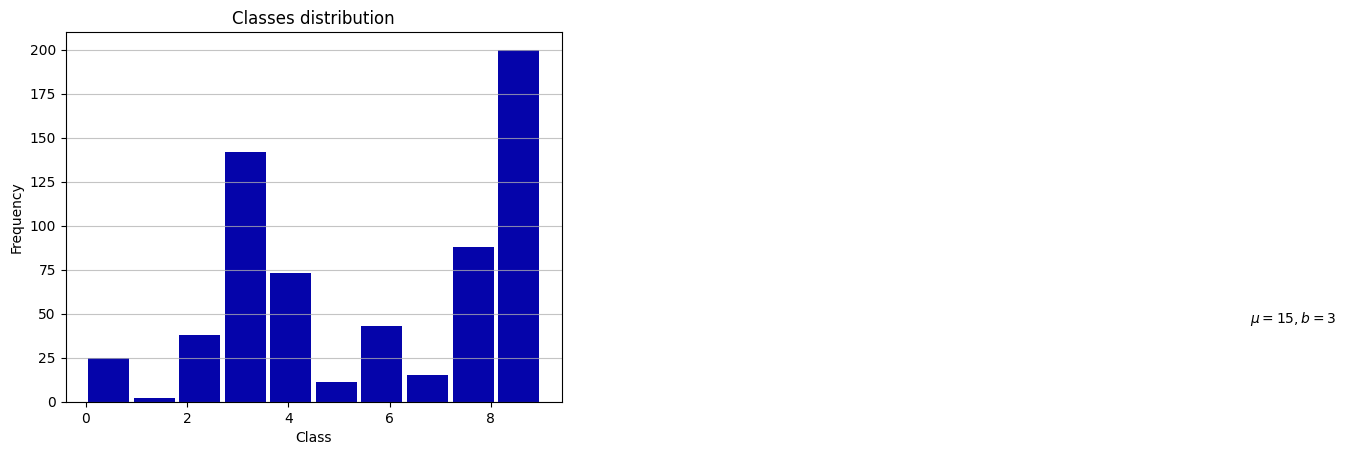

In [30]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[1] for r in cleaned_expression_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# kinase act

(0.0, 210.0)

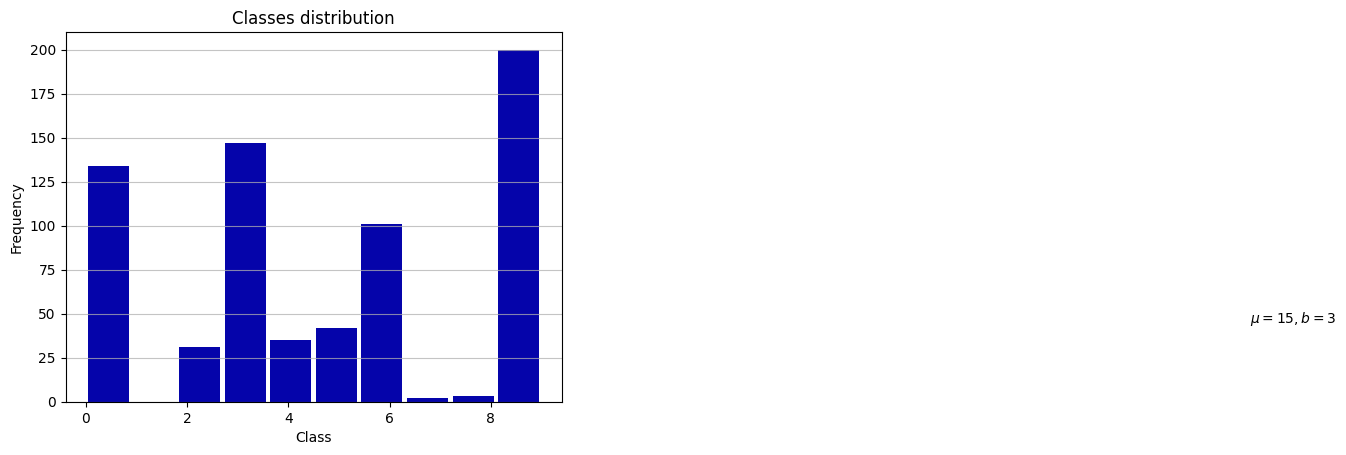

In [31]:
n, bins, patches = plt.hist(x=[r[1] for r in cleaned_kinaseact_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)